# Hazard assessment: climate projections

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

In this third notebook of the workflow, we are combining a response model constructed in the previous [response surface methodology](hazard_assessment_response.ipynb) notebook with temperature and precipitation projections from climate model runs to obtain concrete projections of wildfire hazard for the future.

## Preparation work

### Load libraries

:::{admonition} Information about the libraries used in this workflow
:class: hint dropdown

- [pathlib](https://docs.python.org/3/library/pathlib.html) - Convenient file path manipulation.
- [json](https://docs.python.org/3/library/json.html) - General data en- and decoding.
- [pickle](https://docs.python.org/3/library/pickle.html) - Python-specific object en- and decoding.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - Zip archive handling.
- [numpy](https://numpy.org/) - A powerful library for numerical computations, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/) - A data manipulation and analysis library, essential for working with structured data in tabular form.
- [geopandas](https://geopandas.org/en/stable/index.html) - Geometric operations for geospatial data in pandas.
- [xarray](https://docs.xarray.dev/en/stable/) - Library for working with labelled multi-dimensional arrays.
- [rioxarray](https://corteva.github.io/rioxarray/html/index.html) - Geospatial operations for xarray based on GDAL/rasterio.
- [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) - Statistical computations.
- [earthkit.plots](https://earthkit-plots.readthedocs.io/en/latest/) - Visualisation tools and templates designed for earth science data.

Additional dependencies depending on data and visualization choices:

- [cdsapi](https://cds.climate.copernicus.eu/how-to-api) - Interaction with the Climate Data Store.
- [bokeh](https://docs.bokeh.org/en/latest/index.html) - Browser-based interactive visualizations.
:::

In [1]:
import json
import pathlib
import pickle
import zipfile

import earthkit.plots as ekp
import geopandas as gpd
import numpy as np
import pandas as pd
import scipy.stats
import xarray as xr

### Set location

Used for labelling and to locate data from previous steps of the workflow.

In [2]:
location = "Andalucía"

### Path configuration

In [3]:
data_dir = pathlib.Path("./data")

# Shapefile of region that is analysed
region_path = data_dir / location / "region"

# Temperature and precipitation projections: output of step 1, input for step 2
proj_path = data_dir / "projections_dt_dp.nc"

### Load region geometry

In [4]:
region = gpd.read_file(region_path)

## Step 1: Prepare climate projections

To evaluate the response model, projections of temperature and precipitation change are required.
These variables are almost always part of the standard output of climate model runs and therefore widely available from various modelling efforts (certainly more ubiquitous than projections of FWI).

We show by example how a dataset of temperature and precipitation projections is prepared for the next steps of the workflow.

:::{tip}

Take the opportunity and integrate projections of temperature and precipitation (change) for your region of interest into the workflow here.
If you have projections specifically made for your region or a dataset with a larger number of models, we strongly recommend to utilize them below for best results.

You can go directly to Step 2 if you already have a prepared dataset of temperature and precipitation change.
:::

The Copernicus Climate Data Store (CDS) provides access to a dataset of [climate indicators for Europe from 1940 to 2100 derived from reanalysis and climate projections](https://cds.climate.copernicus.eu/datasets/sis-ecde-climate-indicators?tab=overview) based on ERA5 reanalysis data and EURO-CORDEX climate model runs.
We choose this dataset here mainly because it is convenient to access and relatively small in size.
The dataset covers geographical Europe (similar to the FWI dataset of [El Garroussi et al. 2024](https://doi.org/10.1038/s41612-024-00575-8)) at a moderate spatial resolution (0.25° horizontal).

:::{note}

The climate indicator dataset from CDS also includes timeseries of FWI.
However, our approach of evaluating a response model with projections of temperature and precipitation allows us to determine the response of statistical quantities (probability of exceedance, average fire season length) with higher reliability and temporal resolution than we could from these timeseries directly.
:::

### Configure dataset

In [ ]:
dataset = "sis_ecde_climate_indicators"
clim_dir = data_dir / dataset

Select a representative concentration pathway (RCP; emission scenario):

In [ ]:
scenario = ["rcp4_5"]  # choose from rcp4_5 and rcp8_5

### Download climate indicators from CDS

To access the data on CDS, you have to create an ECMWF account.
See the [guide on how to set up the API](https://cds.climate.copernicus.eu/how-to-api) for more information.

In [ ]:
import cdsapi

URL = "https://cds.climate.copernicus.eu/api"
KEY = None  # add your key or provide via ~/.cdsapirc

client = cdsapi.Client(url=URL, key=KEY)

In [ ]:
# Download data for the selected scenario from CDS (comes in a zip archive)
clim_path_zip = client.retrieve(dataset, {
    "origin": "projections",
    "gcm": ["ec_earth", "hadgem2_es", "ipsl_cm5a_mr", "mpi_esm_lr", "noresm1_m"],
    "rcm": ["cclm4_8_17", "hirham5", "racmo22e", "rca4", "wrf381p"],
    "experiment": scenario,
    "ensemble_member": ["r12i1p1", "r1i1p1", "r3i1p1"],
    "temporal_aggregation": ["yearly"],
    "spatial_aggregation": "gridded",
    "variable": [
        "mean_temperature",
        "total_precipitation"
    ]
}).download(clim_dir.with_suffix(".zip"))

Extract all files in the downloaded zip archive:

In [ ]:
with zipfile.ZipFile(clim_path_zip, "r") as zObject:
    zObject.extractall(path=clim_dir)

Remove the zip archive to reduce disk usage:

In [ ]:
clim_path_zip.unlink()

### Load and merge

Load all files for the specified RCP scenario and merge all model runs into a single dataset:

In [ ]:
def filename_to_coords(ds):
    # Metadata coverage varies between files, fall back to parsing filename
    path = pathlib.Path(ds.encoding["source"])
    _, _, _, rcp, rcm, gcm, member, _, _ = path.stem.split("-")
    # Clean up scenario name for labelling
    rcp = rcp.replace("rcp_", "RCP").replace("_", ".")
    # Add metadata coordinates for convenient access after merging
    ds = ds.assign_coords({"run": f"{gcm}-{rcm}-{member}", "scenario": rcp})
    return ds.expand_dims(["run", "scenario"])

clim_files = list(clim_dir.glob("*.nc"))
clim_data = xr.open_mfdataset(clim_files, preprocess=filename_to_coords, combine_attrs="drop")

### Compute temperature and precipitation change

Compute decadal means to average out year-to-year variability:

In [ ]:
def decadal_mean(ds):
    return ds.groupby(10 * (ds.coords["time"].dt.year // 10)).mean().rename({"year": "decade"})

# Stop in 2099 to avoid single-year 210X decade
clim_data_dec = decadal_mean(clim_data.sel({"time": slice("1950", "2099")}))

Compute the reference for determining change:

In [ ]:
clim_data_ref = clim_data.sel({"time": slice("1981", "2010")}).mean(dim="time").persist()

:::{tip}

You can customize the reference period according to your interests.
By default, we have chosen 1981-2010, which matches the time period covered by the historical FWI simulations of [El Garroussi (2024)](https://doi.org/10.5281/zenodo.10458186).
:::

Compute changes in temperature and precipitation for evaluation of the response surface model:

In [ ]:
clim_data_diff = xr.Dataset({
    # Temperature as absolute change
    "dt": clim_data_dec["tasAdjust"] - clim_data_ref["tasAdjust"],
    # Precipitation as relative change in percent
    "dp": 100 * (clim_data_dec["prAdjust"] / clim_data_ref["prAdjust"]) - 100
})

### Export data

Write the projections of change to disk.
This dataset still covers the full European domain.

In [ ]:
# Optimize the spatial coordinates for rasterio/rioxarray
clim_data_diff = clim_data_diff.rio.write_crs("EPSG:4326")
clim_data_diff = clim_data_diff.rename({"lon": "x", "lat": "y"})

clim_data_diff.to_netcdf(proj_path)

## Step 2: Import temperature and precipitation change projections

### Select scenario

Select a representative concentration pathway (RCP; emission scenario) for labelling and data extraction (if applicable):

In [5]:
scenario = "RCP4.5"

### Read and clip data

Load the projections of temperature and precipitation change and cut to the region of interest:

In [6]:
clim_data_diff = (
    xr.open_dataset(proj_path, decode_coords="all")
    # Choose a specific climate scenario
    .sel({"scenario": scenario})
    # Keep data for 20xx decades
    .sel({"decade": slice(2000, None)})
    # Cut to the selected region
    .rio.clip(region.geometry, all_touched=True)
)

:::{tip}

- Adapt the data loading/processing to your needs, in particular if you are using a different climate dataset than obtained in Step 1.
- You can apply [`.buffer(...)`](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html#GeoSeries.buffer) to `region.geometry` in the clipping step to expand the region for which climate data is extracted if you find that the clipping is too aggressive in removing grid points along the boundaries of your region.
:::

:::{important}

The temperature change must be given as absolute change in °C and precipitation as relative change in % for compatibility with the response surface models constructed in previous steps of the workflow.
:::

### Maps of model-mean projected change

Visualize model-mean projections of temperature and precipitation change.
We select 3 decades to illustrate the evolution over time.

In [7]:
decades = [2030, 2060, 2090]

In [8]:
# Plotting style for temperature change maps
dt_plot_style = ekp.styles.Style(
    levels=[-3., -2.5, -2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3.],
    extend="both",
    colors="RdBu_r",
    units_label="°C"
)

# Plotting style for precipitation change maps
dp_plot_style = ekp.styles.Style(
    levels=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25],
    extend="both",
    colors="BrBG",
    units_label="%"
)

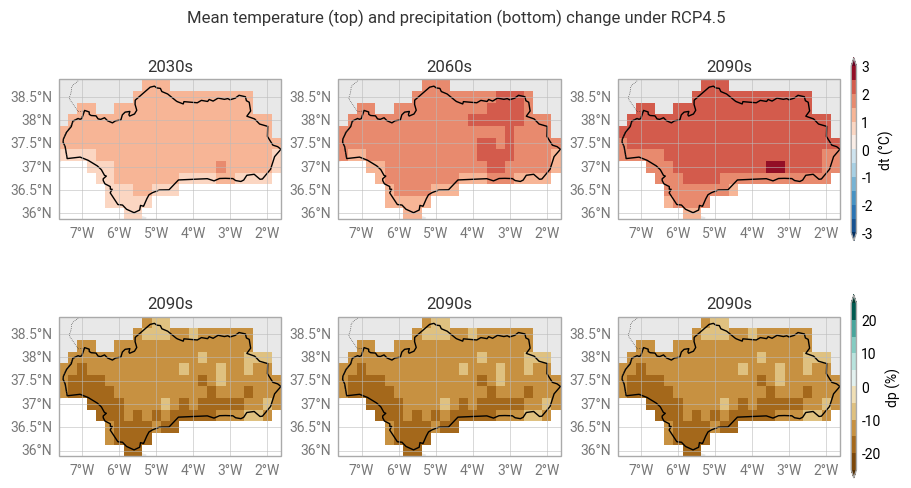

In [9]:
fig = ekp.Figure(rows=2, columns=3, size=(9, 5))
fig.title(f"Mean temperature (top) and precipitation (bottom) change under {scenario}")

for decade in decades:
    subplot = fig.add_map()
    subplot.title(f"{decade}s")
    subplot.block(clim_data_diff["dt"].sel({"decade": decade}).mean(dim="run"), style=dt_plot_style)
    region.plot(ax=subplot.ax, edgecolor="black", facecolor="none")  # Outline for selected region
subplot.legend(location="right")

for year in decades:
    subplot = fig.add_map()
    subplot.title(f"{decade}s")
    subplot.block(clim_data_diff["dp"].sel({"decade": decade}).mean(dim="run"), style=dp_plot_style)
    region.plot(ax=subplot.ax, edgecolor="black", facecolor="none")
subplot.legend(location="right")

fig.land()
fig.borders()
fig.gridlines()

### Spatially aggregated statistics

For an alternative view on the change projections, we aggregate in space but keep the full temporal evolution.
Take an area-weighted average over the region and visualize the statistics of the multi-model ensemble:

In [10]:
# For a regular latitude-longitude grid, the cosine of latitude gives appropriate weighting
area_weights = np.cos(np.deg2rad(clim_data_diff.coords["y"]))

clim_change = clim_data_diff.weighted(area_weights).mean(dim=["y", "x"], keep_attrs=True)

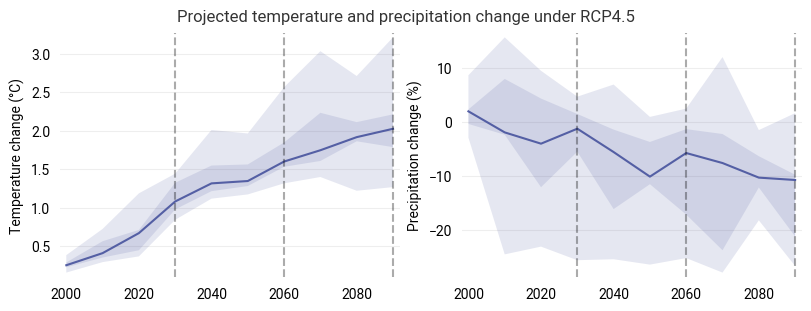

In [11]:
fig = ekp.Figure(rows=1, columns=2, size=(8, 3))
fig.title(f"Projected temperature and precipitation change under {scenario}")

subplot = fig.add_subplot()
subplot.quantiles(
    clim_change["dt"],
    x=clim_change.coords["decade"],
    dim="run",
    quantiles=[0.0, 0.25, 0.5, 0.75, 1.0]
)
subplot.ax.set_ylabel("Temperature change (°C)")
for year in decades:
    subplot.ax.axvline(year, color="black", alpha=0.33, linestyle="dashed")

subplot = fig.add_subplot()
subplot.quantiles(
    clim_change["dp"],
    x=clim_change.coords["decade"],
    dim="run",
    quantiles=[0.0, 0.25, 0.5, 0.75, 1.0]
)
subplot.ax.set_ylabel("Precipitation change (%)")
for decade in decades:
    subplot.ax.axvline(decade, color="black", alpha=0.33, linestyle="dashed")

The central line shows the median response of the ensemble at each timestep, while the shaded areas highlight the 25-75 percentile (dark) and total (light) ranges of the model ensemble.

:::{note}

In this and similar visualization in the following, the median response is computed individually for each decade and does not represent a consistent evolution from a single climate model run in general.
:::

## Step 3: Load the response surface model

Specify the name of a response model as assigned during its export:

In [12]:
hazard_name = "hazard_pe_60.0"

Load the corresponding model and its configuration information for labelling:

In [13]:
hazard_dir = data_dir / location / hazard_name

# Response surface model
with open(hazard_dir / "response_model.pkl", "rb") as f:
    response_model = pickle.load(f)

# Metadata
with open(hazard_dir / "response_info.json", "r") as f:
    response_info = json.load(f)

response_label = response_info["label"]
response_units = response_info["units"]

For visualization of the response surface, sample the model:

In [14]:
sample = pd.MultiIndex.from_product([
    np.linspace(-40, 60, 101),  # range of sampled precipitation change
    np.linspace(0.0, 5.0, 101)  # range of sampled temperature change
], names=["dp", "dt"])

response_sampled = pd.DataFrame(
    response_model.predict(sample.to_frame()),
    index=sample,
    columns=["response"]
).to_xarray()

response_sampled = response_sampled["response"]

A quick visualization of the response surface to verify that the loaded model is as expected:

In [15]:
# Adapt the style to the loaded response variable
pe_plot_style_absolute = ekp.styles.Style(
    levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    colors="YlOrBr",
    units_label=response_units
)

Text(0, 0.5, 'Precipitation change (%)')

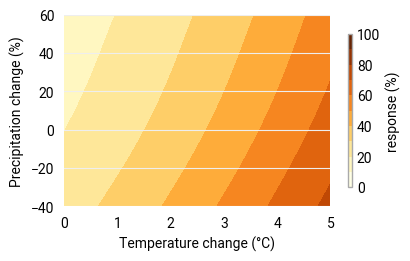

In [16]:
figure = ekp.Figure(rows=1, columns=1, size=(4, 2.5))

subplot = figure.add_subplot()
subplot.contourf(response_sampled, style=pe_plot_style_absolute)
subplot.legend(location="right")
subplot.ax.set_xlabel("Temperature change (°C)")
subplot.ax.set_ylabel("Precipitation change (%)")

## Step 4: Evaluate the response to climate change

We overlay projections of temperature and precipitation change onto the response surface.
This allows us to

1. translate the projections of temperature and precipitation change to projections of wildfire hazard and
2. examine the sensitivity of wildfire risk to uncertainties in the projections.

The response surface, once constructed, provides a fast and easy method to estimate wildfire hazard and its sensitivity for a given evolution of yearly averaged temperature and precipitation change.

### Temporal evolution of the climate model ensemble

Fit a probability distribution to the model ensemble for each decade and visualize the evolution of the distribution in time (here for the three decades selected earlier in Step 2).

In [17]:
def fit_pdf(projection):
    data = np.row_stack([projection["dt"], projection["dp"]])
    return scipy.stats.gaussian_kde(data)

def sample_pdf(pdf, x, y):
    xx, yy = np.meshgrid(x, y)
    pdf_sampled = pdf(np.row_stack([xx.flatten(), yy.flatten()])).reshape([y.size, x.size])
    return xr.DataArray(data=pdf_sampled, dims=(y.name, x.name), coords=[y, x], name="pdf")

/opt/conda/lib/python3.11/site-packages/earthkit/plots/styles/__init__.py:408: UserWarning: The following kwargs were not used by contour: 'transform_first'
  return ax.contour(x, y, values, *args, **kwargs)


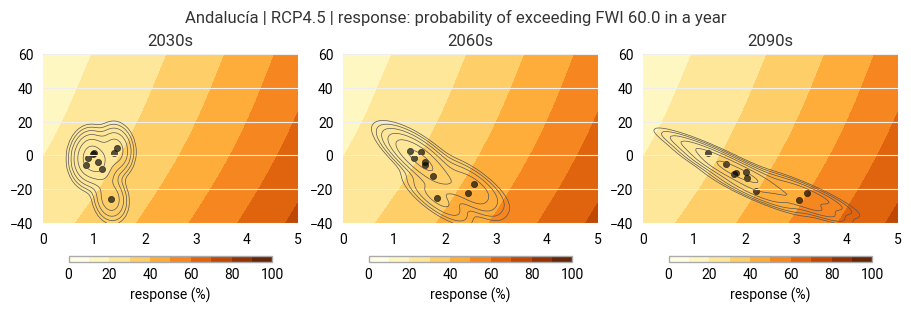

In [18]:
figure = ekp.Figure(rows=1, columns=3, size=(9, 3))
figure.title(f"{location} | {scenario} | response: {response_label}")

for decade in decades:
    subplot = figure.add_subplot()
    subplot.title(f"{decade}s")

    subplot.contourf(response_sampled, style=pe_plot_style_absolute)
    subplot.legend()

    projections_decade = clim_change.sel({"decade": decade})
    projections_pdf_sampled = sample_pdf(
        fit_pdf(projections_decade),
        response_sampled.coords["dt"],
        response_sampled.coords["dp"]
    )
    subplot.contour(projections_pdf_sampled, colors="black", levels=np.logspace(-3, -1, 7))
    subplot.scatter(x=projections_decade["dt"], y=projections_decade["dp"], s=20, color="black", alpha=0.66)

The background shows the known response surface.
The points mark the individual model runs while the contours show the fitted distribution.

### Plume plot of evaluated response

Evaluate the response model with the timeseries of temperature and precipitation change for each model run.

First, define a general function to evaluate the response model:

In [19]:
def points_response(ds):
    df = ds.to_dataframe()[["dp", "dt"]]
    df_avail = df.dropna()  # model can't handle NaN
    out = pd.Series(
        response_model.predict(df_avail).squeeze(),
        index=df_avail.index,
        name="response"
    )
    out = out.reindex(df.index, fill_value=np.nan).to_xarray()
    if ds.rio.crs is not None:
        out = out.rio.write_crs(ds.rio.crs)
    return out

Then, evaluate with the area-weighted regional mean timeseries computed in Step 2:

In [20]:
fwi_future = points_response(clim_change)

Text(0, 0.5, 'response (%)')

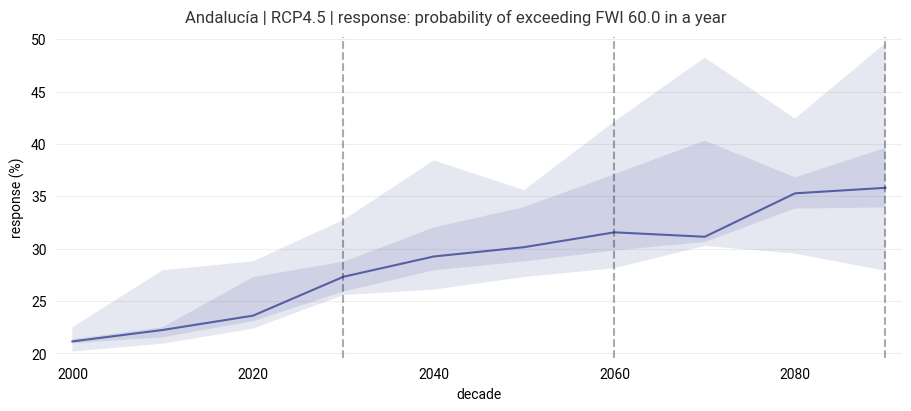

In [21]:
figure = ekp.Figure(size=(9, 4))
figure.title(f"{location} | {scenario} | response: {response_label}")

subplot = figure.add_subplot()
subplot.quantiles(
    fwi_future,
    x=fwi_future.coords["decade"],
    dim="run",
    quantiles=[0.0, 0.25, 0.5, 0.75, 1.0],
    alpha=0.15
)

for decade in decades:
    subplot.ax.axvline(decade, color="black", alpha=0.33, linestyle="dashed")

subplot.ax.set_xlabel("decade")
subplot.ax.set_ylabel(f"response ({response_units})")

The diagram shows the evolution of the response variable (hazard indicator) for the region.
The central line follows the median response of the ensemble at each timestep, while the shaded areas highlight the 25-75 percentile (dark) and total (light) ranges of the model ensemble.

### Response for individual model runs (interactive)

As a complementary view, we can overlay the temperature and precipitation change projection of each model run onto the response surface as a "trajectory" and extract the corresponding temporal evoluation of the response.
This type of visualization can get crowded even for a small ensemble, so we choose an interactive visualization with linked data between panels and the option to selectively zoom.

First, set up the bokeh library for interactive plotting:

In [ ]:
import bokeh.layouts
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Set up bokeh output in notebook
from bokeh.io import output_notebook
from bokeh.resources import INLINE
output_notebook(INLINE)

In [ ]:
def build_bokeh_run_source(run_data):
    return bokeh.models.ColumnDataSource(data={
        "decade": run_data["decade"].values,
        "dt": run_data["dt"].values,
        "dp": run_data["dp"].values,
        "res": points_response(run_data).values
    })

# Two panels (response surface and evaluated response)
fig_surf = bokeh.plotting.figure(width=700, height=450)
fig_ens = bokeh.plotting.figure(width=700, height=300)

# Response surface background
contour_renderer = fig_surf.contour(
    x=response_sampled["dt"].values,
    y=response_sampled["dp"].values,
    z=response_sampled,
    levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    fill_color=bokeh.palettes.YlOrBr[9][::-1]
)
colorbar = contour_renderer.construct_color_bar()
fig_surf.add_layout(colorbar, "right")

# Individual ensemble members
for run in clim_change.coords["run"]:
    run_src = build_bokeh_run_source(clim_change.sel({"run": run}))
    fig_ens.line("decade", "res", source=run_src, line_width=3, line_color="black",
            line_alpha=0.3, hover_line_alpha=1.0, name=str(run.values))
    fig_surf.line("dt", "dp", source=run_src, line_width=2.5, line_color="black",
            line_alpha=0.3, hover_line_alpha=1.0, name=str(run.values))

# Also show ensemble mean response
mean_src = build_bokeh_run_source(clim_change.mean(dim="run"))
fig_ens.line("decade", "res", source=mean_src, line_width=3, line_color="blue",
        line_alpha=0.6, hover_line_alpha=1.0, name="ensemble mean")
fig_surf.line("dt", "dp", source=mean_src, line_width=3, line_color="blue",
        line_alpha=0.6, hover_line_alpha=1.0, name="ensemble mean")

# Show values on hover
fig_ens.add_tools(bokeh.models.HoverTool(line_policy='nearest', tooltips="$name<br>(@decade, dt=@dt°C, dp=@dp%)"))
fig_surf.add_tools(bokeh.models.HoverTool(line_policy='nearest', tooltips="$name<br>(@year, response=@res)"))

for fig in [fig_ens, fig_surf]:
    fig.toolbar.autohide = True

bokeh.plotting.show(
    bokeh.layouts.column(fig_ens, fig_surf)
)

Each grey/black line shows the response of an individual model run.
The blue line shows the ensemble mean response.
Move the mouse over a line to highlight the corresponding line in the other panel.

### Ensemble statistics response maps

Instead of aggregating the temperature and precipitation change in space, we can evaluate the response for each grid point of the climate model data individually.

In [22]:
response = points_response(clim_data_diff)

:::{note}

This approach only offers a "partial" assessment of the spatially resolved response.
The response model is evaluated at each grid point but the model itself is built from spatially aggregated data.
:::

Visualize the minimum, median and maximum response in the ensemble for the three selected decades on maps:

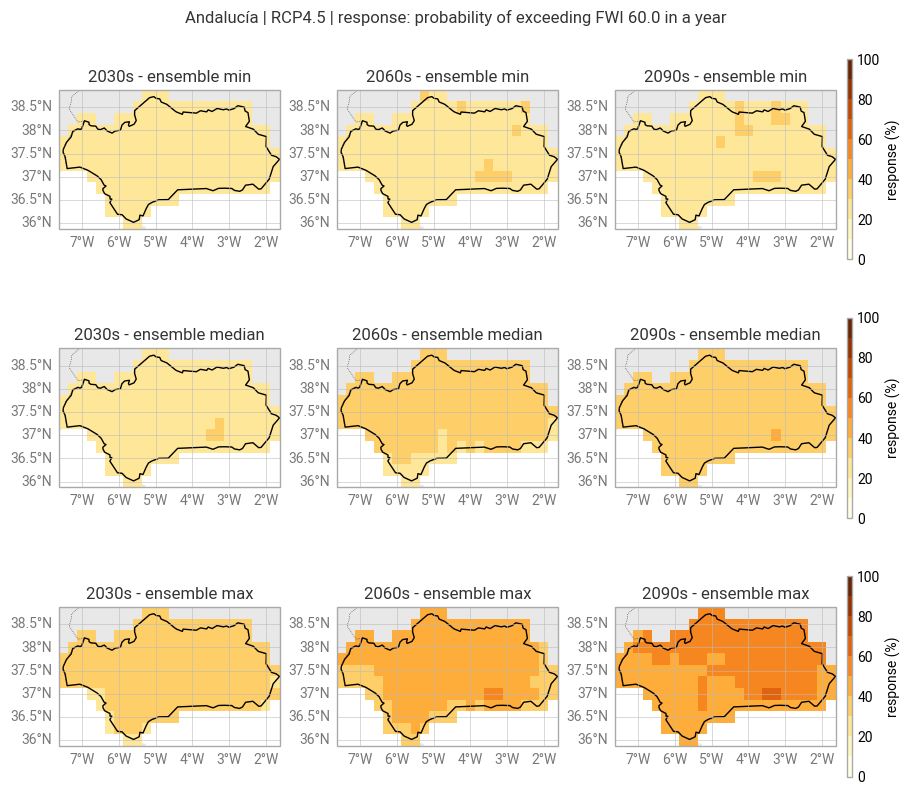

In [23]:
figure = ekp.Figure(rows=3, columns=3, size=(9, 8))
figure.title(f"{location} | {scenario} | response: {response_label}")

for agg in ["min", "median", "max"]:
    for decade in decades:
        subplot = figure.add_map()
        subplot.title(f"{decade}s - ensemble {agg}")
        subplot.block(
            getattr(response.sel({"decade": decade}), agg)(dim="run"),
            style=pe_plot_style_absolute
        )
        region.plot(ax=subplot.ax, edgecolor="black", facecolor="none")  # Outline of region
    subplot.legend(location="right")

figure.land()
figure.borders()
figure.gridlines()

## Step 5: Export data

Export the data behind the response maps for use as a hazard indicator in the risk assessment.

In [24]:
# Order spatial coordinates last
response = response.transpose("decade", "run", "y", "x")

# Attach information from response model and RCP scenario
response.attrs = {
    **response_info,
    "rcp": scenario
}
response.to_netcdf(hazard_dir / f"response_{scenario}.nc")

## Summary

We have created projections of wildfire hazard by evaluating a response model with temperature and precipitation change timeseries derived from an ensemble of climate model runs.
The projected hazard response was explored in time and space.

This concludes the hazard assessment part of the workflow.
In the following risk assessment ([affected population](risk_assessment_population.ipynb)), we combine the hazard projections with projections of population and count the population affected by a specific level of hazard in the future.